# 📊 Hackathon – Jour 2 : Exploration de données

Ce notebook présente l'analyse exploratoire des données bruit et trafic aérien pour la région Île-de-France.

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import folium

# Affichage plus lisible
pd.set_option("display.max_columns", None)


## 1. Chargement des données

In [4]:

bruit = pd.read_csv("Data/bruit_survol.csv")
opensky = pd.read_csv("Data/opensky_snapshot.csv")
flights = pd.read_csv("Data/flights_history.csv")

print("Bruit:", bruit.shape)
print("OpenSky:", opensky.shape)
print("Flights:", flights.shape)


Bruit: (50, 8)
OpenSky: (50, 11)
Flights: (50, 9)


## 2. Nettoyage des données

In [5]:

# Conversion des dates
bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"])
opensky["time_position_unix"] = pd.to_datetime(opensky["time_position_unix"], unit="s")
flights["first_seen_iso"] = pd.to_datetime(flights["first_seen_iso"])
flights["last_seen_iso"] = pd.to_datetime(flights["last_seen_iso"])

# Suppression doublons
bruit = bruit.drop_duplicates()
opensky = opensky.drop_duplicates()
flights = flights.drop_duplicates()

# Aperçu
bruit.head()


,station_id,station_name,timestamp_iso,LAeq_dB,Lmax_dB,latitude,longitude,airport
0,SURV006,Le Bourget - Station 2,2025-09-22 08:12:00,58.0,63.6,48.925908,2.476151,CDG
1,SURV006,Le Bourget - Station 2,2025-09-22 02:37:00,53.6,58.9,48.963169,2.438372,ORY
2,SURV002,Aéroport Charles de Gaulle - Sud,2025-09-22 07:15:00,52.2,59.8,48.881463,2.376714,CDG
3,SURV006,Le Bourget - Station 2,2025-09-21 17:24:00,56.5,56.8,48.831003,2.371886,CDG
4,SURV005,Le Bourget - Station 1,2025-09-21 21:36:00,53.9,60.8,48.863679,2.329385,CDG


## 3. Analyse exploratoire des données

In [9]:

# Adapter ici selon les colonnes affichées ci-dessus
print("Statistiques bruit:")
# Exemple d’utilisation de colonnes trouvées, à adapter selon affichage
cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
if cols_bruit:
    print(bruit[cols_bruit].describe())
else:
    print("Aucune colonne numérique trouvée dans bruit.")

print("\nStatistiques vols:")
cols_opensky = [col for col in opensky.columns if opensky[col].dtype in ['float64', 'int64']]
if cols_opensky:
    print(opensky[cols_opensky].describe())
else:
    print("Aucune colonne numérique trouvée dans opensky.")


Statistiques bruit:
         LAeq_dB    Lmax_dB   latitude  longitude
count  50.000000  50.000000  50.000000  50.000000
mean   55.262000  61.254000  48.894350   2.403456
std     4.054521   5.205461   0.039912   0.052620
min    46.100000  49.900000  48.795210   2.300622
25%    52.125000  57.525000  48.863337   2.360985
50%    55.450000  60.800000  48.898663   2.408981
75%    57.775000  64.975000  48.917811   2.441293
max    66.200000  73.600000  48.975447   2.536008

Statistiques vols:
       longitude   latitude  baro_altitude_m  velocity_m_s  heading_deg  \
count  50.000000  50.000000        50.000000     50.000000    50.000000   
mean    2.363079  48.870766      8883.440000    210.860000   194.882000   
std     0.085451   0.062975      4296.970927     60.242537   111.095988   
min     2.187034  48.764192         0.000000     88.000000    18.600000   
25%     2.315711  48.824275      6182.500000    174.125000   101.925000   
50%     2.370317  48.861708      9163.500000    208.900000  

## 4. Visualisations

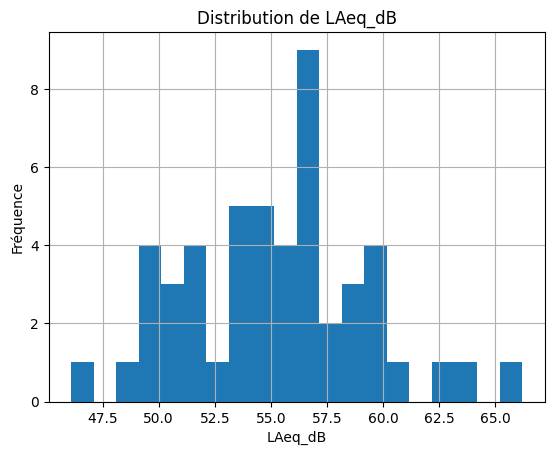

In [ ]:
# Histogramme du bruit (première colonne numérique disponible)
num_cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
if num_cols_bruit:
    bruit[num_cols_bruit[0]].hist(bins=20)
    plt.xlabel(num_cols_bruit[0])
    plt.ylabel("Fréquence")
    plt.title(f"Distribution de {num_cols_bruit[0]}")
    plt.show()
else:
    print("Aucune colonne numérique trouvée dans bruit pour l'histogramme.")

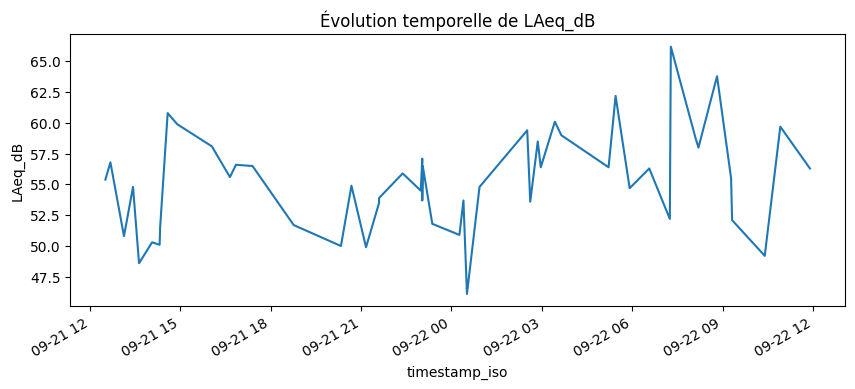

In [15]:
# Série temporelle bruit (triée par date pour une courbe correcte)
if "timestamp_iso" in bruit.columns and num_cols_bruit:
    bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"], errors="coerce")
    df_plot = bruit.dropna(subset=["timestamp_iso", num_cols_bruit[0]]).sort_values("timestamp_iso")
    if not df_plot.empty:
        df_plot.set_index("timestamp_iso")[num_cols_bruit[0]].plot(figsize=(10,4))
        plt.ylabel(num_cols_bruit[0])
        plt.title(f"Évolution temporelle de {num_cols_bruit[0]}")
        plt.show()
    else:
        print("Aucune donnée valide pour la série temporelle.")
else:
    print("Impossible d'afficher la série temporelle : colonne timestamp_iso ou numérique manquante.")

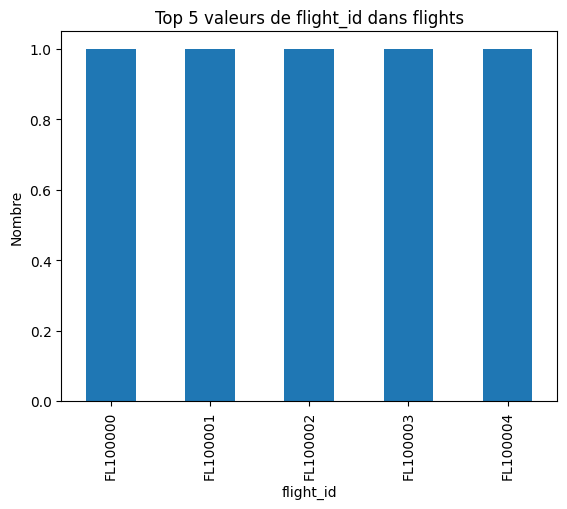

In [16]:
# Top 5 origines de vols (première colonne catégorielle disponible)
cat_cols_flights = [col for col in flights.columns if flights[col].dtype == 'object']
if cat_cols_flights:
    top_origins = flights[cat_cols_flights[0]].value_counts().head(5)
    top_origins.plot(kind="bar")
    plt.title(f"Top 5 valeurs de {cat_cols_flights[0]} dans flights")
    plt.ylabel("Nombre")
    plt.show()
else:
    print("Aucune colonne catégorielle trouvée dans flights pour le top 5.")

In [ ]:
# Carte interactive des mesures de bruit

import folium  # Assure que folium est bien importé

lat_col = next((col for col in bruit.columns if 'lat' in col.lower()), None)
lon_col = next((col for col in bruit.columns if 'lon' in col.lower()), None)
val_col = num_cols_bruit[0] if num_cols_bruit else None

if lat_col and lon_col and val_col:
    # Centre de la carte : moyenne des coordonnées
    m = folium.Map(location=[bruit[lat_col].mean(), bruit[lon_col].mean()], zoom_start=10)
    for _, row in bruit.dropna(subset=[lat_col, lon_col, val_col]).iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=5,
            color='blue',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"{val_col}: {row[val_col]:.2f}"
        ).add_to(m)
    try:
        from IPython.display import display
        display(m)
    except ImportError:
        m
else:
    print("Colonnes latitude/longitude ou valeur de bruit manquantes pour la carte.")

NameError: name 'folium' is not defined